In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ingredients = pd.read_excel("Data Set Feedcalculator.xlsx", sheet_name="Ingredient Database")
ingredient_rules = pd.read_excel("Data Set Feedcalculator.xlsx", sheet_name="Ingredient Rules")
nutrient_rules = pd.read_excel("Data Set Feedcalculator.xlsx", sheet_name="Nutrient Rules")

In [3]:
available_ingredients = ingredients[ingredients.Availability][
    ['Name', 'Reference name', 'Price'] + list(nutrient_rules.Nutrient)].set_index('Reference name')

In [4]:
# Extracting bounds for easier access
nutrient_bounds = {nut: (lb if not pd.isna(lb) else 0,
                         ub if not pd.isna(ub) else None) 
                   for nut, lb, ub in
                   zip(nutrient_rules.Nutrient, nutrient_rules['Lower Bound'], nutrient_rules['Upper Bound'])
                   }
# I made some adjustments to the given code. Firstly I extract all unavailable ingredients from the bounds dic
ingredient_bounds = {
    ing: (lb if not pd.isna(lb) else 0,
          ub if not pd.isna(ub) else None)
    for ing, lb, ub in zip(ingredient_rules.Ingredient, ingredient_rules['Lower Bound'], ingredient_rules['Upper Bound'])
    if ing in available_ingredients.index
}
# Then I add the remaining available ingredients with the bounds (0, None)
for ing in available_ingredients.index:
    if ing not in ingredient_bounds:
        ingredient_bounds[ing] = (0, None)


combined_ingredient_rules = []
set_of_available_ingredients = set(available_ingredients.index)
for c in ['Unnamed: ' + str(i) for i in range(5, 13)]:
    aux = ingredient_rules[[c]].dropna().values
    aux = [v[0] for v in aux]
    upperbound = aux[0]
    ingredients_in_rule = set(aux[1:]).intersection(set_of_available_ingredients)
    if ingredients_in_rule:
        combined_ingredient_rules.append((upperbound, ingredients_in_rule))

1.1 Linear model
Consider the same model as in Lecture 8 and extend it to include the ‘combined ingredient rules’ that 
you see extracted in the the companion notebook. These rules stipulate upper bounds for several combinations 
of ingredients. For example, the first combined ingredient rule specifies that the total sum of cotton, 
sunflower, gncake and copra may not exceed 0.17 (17%) of the total feed mix. Note that some ingredients 
are specified as “unavailable”, such ingredients can be discarded from our model. Thus the first rule 
combination can be reduced to the sum amount of cotton and sunflower.

In [5]:
# 1.1
# Initializing the model
model = ConcreteModel()
# Sets
model.I = Set(initialize=ingredient_bounds.keys())
model.N = Set(initialize=nutrient_bounds.keys())
# x- the variable which shows the quantity of ingredient i to be used
model.x = Var(model.I, within=NonNegativeReals)  # Quantity of ingredient i to be used
# The objective is to minimize the cost
model.cost = Objective(expr=sum(model.x[i] * available_ingredients.loc[i, 'Price'] for i in model.I), sense=minimize)
# Nutrients constraint
def nutrient_bounds_rule(model, n):
    return nutrient_bounds[n][0], sum(model.x[i] * available_ingredients.loc[i, n] for i in model.I),  nutrient_bounds[n][1]

model.nutrient_constr = Constraint(model.N, rule=nutrient_bounds_rule)
# Ingredients constraint
def ingredient_bounds_rule(model, i):
    return ingredient_bounds[i][0], model.x[i], ingredient_bounds[i][1]

model.ingredient_constr = Constraint(model.I, rule=ingredient_bounds_rule)
# Combined ingredients constraint
def combined_ingredients_rule(model, rule_idx):
    upper_bound, ingredients_combination = combined_ingredient_rules[rule_idx]
    return sum(model.x[i] for i in ingredients_combination) <= upper_bound

model.combined_ingredients_constr = Constraint(range(len(combined_ingredient_rules)), rule=combined_ingredients_rule)
# Constraint to ensure that the total sum equals 1 or 100%
def total_mix_rule(model):
    return sum(model.x[i] for i in model.I) == 1

model.total_mix_constr = Constraint(rule=total_mix_rule)
#Solving the model (I wanted to use cbc, but it wasn't installing on my device :/)
solver = SolverFactory('glpk',executable="/opt/homebrew/bin/./glpsol")
solver.solve(model)

print("Minimal cost:", model.cost())

Minimal cost: 0.2697643893800598


1.2 Minimize the number of ingredients used
The model you created in 1.1 is linear, with non-negative real valued variables. Extend this model
 by adding a binary variable that states for each ingredient whether it is included in the mix. 
 Alter the model to minimize the number of ingredients used in the mix, while satisfying all 
 requirements, and find the minimal number of ingredients needed. This would be a reasonable 
 approach in the case that the farmer needs to import each ingredient from a different supplier.

In [6]:
# 1.2
# I use the same constraints while changing the objective and adding a binary variable
model = ConcreteModel()
model.I = Set(initialize=ingredient_bounds.keys())
model.N = Set(initialize=nutrient_bounds.keys())

model.x = Var(model.I, within=NonNegativeReals)
# y- the binary variable, y=0 - not included, y=1 - included
model.y = Var(model.I, within=Binary) 
# New objective - minimize sum of y
model.min_ingredients = Objective(expr=sum(model.y[i] for i in model.I), sense=minimize)

def nutrient_bounds_rule(model, n):
    return (nutrient_bounds[n][0], 
            sum(model.x[i] * available_ingredients.loc[i, n] for i in model.I),
            nutrient_bounds[n][1])

model.nutrient_constr = Constraint(model.N, rule=nutrient_bounds_rule)

def ingredient_bounds_rule(model, i):
    return ingredient_bounds[i][0], model.x[i], ingredient_bounds[i][1]

model.ingredient_constr = Constraint(model.I, rule=ingredient_bounds_rule)

def combined_ingredients_rule(model, rule_idx):
    upper_bound, ingredients_combination = combined_ingredient_rules[rule_idx]
    return sum(model.x[i] for i in ingredients_combination) <= upper_bound

model.combined_ingredients_constr = Constraint(range(len(combined_ingredient_rules)),
                                               rule=combined_ingredients_rule)
# I add a constraint which links x and y
def link_binary_to_quantity_rule(model, i):
    return model.x[i] <= model.y[i]

model.link_binary_constr = Constraint(model.I, rule=link_binary_to_quantity_rule)

def total_mix_rule(model):
    return sum(model.x[i] for i in model.I) == 1

model.total_mix_constr = Constraint(rule=total_mix_rule)

solver = SolverFactory('glpk',executable="/opt/homebrew/bin/./glpsol")
solver.solve(model)

print("Minimal number of ingredients:", model.min_ingredients())

Minimal number of ingredients: 5.0


1.3 Minimum cost for the minimum number of ingredients
Now knowing the minimal number of ingredients necessary to satisfy the requirements, 
we want to minimize the cost while using the minimal number of ingredients in the mix.
 Add the number found in 1.2 as a mutable parameter to your model. Determine the mix 
 with the lowest cost for that number of ingredients. Note that the ingredients used 
 in the lowest cost solution may not be the same (albeit in the same number) as the 
 ingredients found in 1.2.

In [7]:
# 1.3
# I can use the model from 1.2 and add a new constraint which locks the amount of ingredients used 
# Also revert the objective back to the one in 1.1
model = ConcreteModel()
model.I = Set(initialize=ingredient_bounds.keys()) 
model.N = Set(initialize=nutrient_bounds.keys())

model.x = Var(model.I, within=NonNegativeReals) 
model.y = Var(model.I, within=Binary) 

model.cost = Objective(expr=sum(model.x[i] * available_ingredients.loc[i, 'Price'] for i in model.I), sense=minimize)

def nutrient_bounds_rule(model, n):
    return (nutrient_bounds[n][0], 
            sum(model.x[i] * available_ingredients.loc[i, n] for i in model.I),
            nutrient_bounds[n][1])

model.nutrient_constr = Constraint(model.N, rule=nutrient_bounds_rule)

def ingredient_bounds_rule(model, i):
    return (ingredient_bounds[i][0], model.x[i], ingredient_bounds[i][1])

model.ingredient_constr = Constraint(model.I, rule=ingredient_bounds_rule)

def combined_ingredients_rule(model, rule_idx):
    upper_bound, ingredients_in_rule = combined_ingredient_rules[rule_idx]
    return sum(model.x[i] for i in ingredients_in_rule) <= upper_bound

model.combined_ingredients_constr = Constraint(range(len(combined_ingredient_rules)),
                                               rule=combined_ingredients_rule)

def link_binary_to_quantity_rule(model, i):
    return model.x[i] <= model.y[i]

model.link_binary_constr = Constraint(model.I, rule=link_binary_to_quantity_rule)

def total_mix_rule(model):
    return sum(model.x[i] for i in model.I) == 1

model.total_mix_constr = Constraint(rule=total_mix_rule)
# Constraint to lock the amount of ingredients to minimum we got in 1.2 
def number_of_ingredients_rule(model):
    return sum(model.y[i] for i in model.I) == 5

model.exact_ingredients_constr = Constraint(rule=number_of_ingredients_rule)

solver = SolverFactory('glpk',executable="/opt/homebrew/bin/./glpsol")
solver.solve(model)

print("Minimal cost for a mix of 5 ingredients:", model.cost())


Minimal cost for a mix of 5 ingredients: 0.34182282508784073


1.4 Navigating the trade-off
You must have noticed that the two previous objectives (minimum cost and 
minimum number of ingredients used) do not agree. After solving for two 
contradictory objectives, you are now asked to suggest a good trade-off: 
a solution that utilizes few ingredients yet still achieves a relatively 
low cost. We could visualize this trade-off by plotting the minimum cost 
as a function of the number of ingredients in the feed. The eventual 
trade-off chosen is subjective, there is no clear answer, but we ask you
to choose a “good” solution and motivate your choice in the report.


In [8]:
# 1.4
# I add an array which holds the graph data (ingredients count and cost)
graph_data=[]
# Wrap the model from 1.3 with a cycle and add the cycle variable to number_of_ingredients_rule. 
# The cycle variable ranges from 5 to 13. 
# 5 is the minimal ingredient count from 1.2, while 13 yields the lowest price from 1.1.

for ingredients_count in range(5,14):
    model = ConcreteModel()
    model.I = Set(initialize=ingredient_bounds.keys()) 
    model.N = Set(initialize=nutrient_bounds.keys())
    
    model.x = Var(model.I, within=NonNegativeReals)
    model.y = Var(model.I, within=Binary)
    
    model.cost = Objective(expr=sum(model.x[i] * available_ingredients.loc[i, 'Price'] for i in model.I), sense=minimize)

    def nutrient_bounds_rule(model, n):
        return (nutrient_bounds[n][0], 
                sum(model.x[i] * available_ingredients.loc[i, n] for i in model.I),
                nutrient_bounds[n][1])
    
    model.nutrient_constr = Constraint(model.N, rule=nutrient_bounds_rule)

    def ingredient_bounds_rule(model, i):
        return ingredient_bounds[i][0], model.x[i], ingredient_bounds[i][1]
    
    model.ingredient_constr = Constraint(model.I, rule=ingredient_bounds_rule)
    
    def combined_ingredients_rule(model, rule_idx):
        upper_bound, ingredients_combination = combined_ingredient_rules[rule_idx]
        return sum(model.x[i] for i in ingredients_combination) <= upper_bound
    
    model.combined_ingredients_constr = Constraint(range(len(combined_ingredient_rules)),
                                                   rule=combined_ingredients_rule)
    
    def link_binary_to_quantity_rule(model, i):
        return model.x[i] <= model.y[i]
    
    model.link_binary_constr = Constraint(model.I, rule=link_binary_to_quantity_rule)
    
    def total_mix_rule(model):
        return sum(model.x[i] for i in model.I) == 1
    
    model.total_mix_constr = Constraint(rule=total_mix_rule)
    
    def number_of_ingredients_rule(model):
        return sum(model.y[i] for i in model.I) == ingredients_count
    
    model.exact_ingredients_constr = Constraint(rule=number_of_ingredients_rule)
    
    solver = SolverFactory('glpk',executable="/opt/homebrew/bin/./glpsol")
    solver.solve(model)
    graph_data.append((ingredients_count, model.cost()))

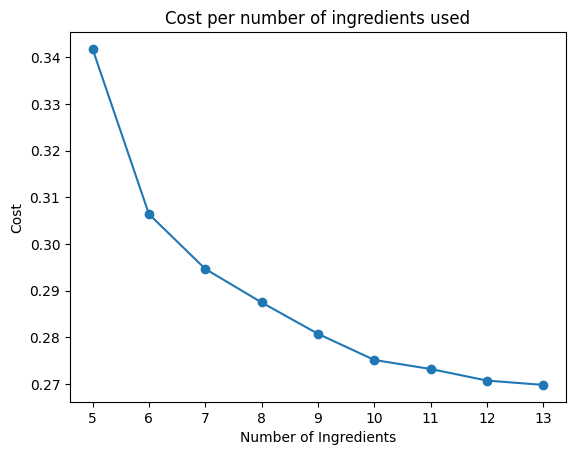

Cost decrease between every count
5-6 - -0.035425
6-7 - -0.011759
7-8 - -0.007194
8-9 - -0.006728
9-10 - -0.005606
10-11 - -0.001934
11-12 - -0.002486
12-13 - -0.000926


In [9]:
x_vals, y_vals = zip(*graph_data)
plt.plot(x_vals, y_vals, marker='o')
plt.xlabel('Number of Ingredients')
plt.ylabel('Cost')
plt.title('Cost per number of ingredients used')
plt.show()

costs = [cost for _, cost in graph_data]
deltas = [costs[i+1] - costs[i] for i in range(len(costs)-1)]
print("Cost decrease between every count")
for i in range(len(deltas)):
    print(f"{graph_data[i][0]}-{graph_data[i+1][0]} - {deltas[i]:.6f}")

 Based on the elbow method and after some quick calculations I suppose that using both 7 and 8 ingredients is optimal,
 8 being my personal preference :)